### Necessary imports

In [1]:
import xarray # used for reading the data.
import matplotlib.pyplot as plt # used to plot the data.
import cartopy.crs as ccrs # Used to georeference data.
import os
from scipy.interpolate import interp2d
import geopandas as gpd
import matplotlib.cm as cm
import numpy as np

### Open data and slice 

Data can be downloaded from https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/

In [2]:
data_path = '/path/to/file_folder/'
wave_path = os.path.join(data_path, 'gfswave.t00z.global.0p16.f000.grib2')

ds = xarray.open_dataset(wave_path, engine='cfgrib')

lat_min = 4.5
lat_max = 30
lon_min = 110
lon_max = 150

swh = ds.swh.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))


### Set boundaries

In [3]:
lats_min = swh.latitude.min().values
lats_max = swh.latitude.max().values
lons_min = swh.longitude.min().values
lons_max = swh.longitude.max().values

lats_size = swh.latitude.shape[0]
lons_size = swh.longitude.shape[0]

lats = np.linspace(lats_max+.05, lats_min+.05, lats_size)
lons = np.linspace(lons_min-.05, lons_max+.05, lons_size)


### Plot swh (significant wave height)

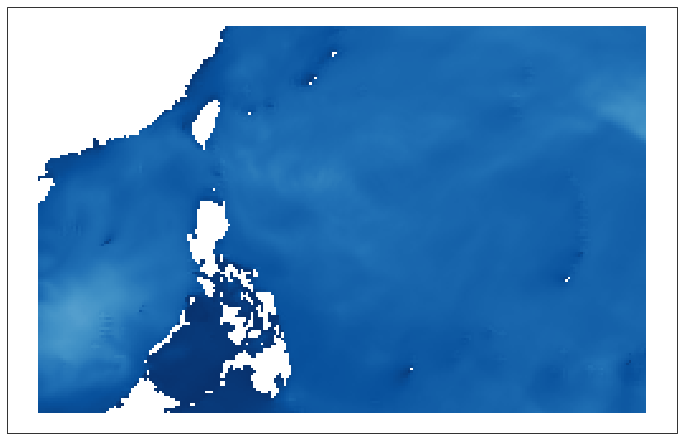

In [4]:
fig = plt.figure(figsize=(12,12))
fig.tight_layout()
fig.subplots_adjust(top=1.25)

crs = ccrs.PlateCarree()

ax = fig.add_subplot(111, facecolor='None', projection=crs)
ax.pcolormesh(lons, lats, swh, cmap=cm.Blues_r, vmin=0, vmax=5)
plt.show()
plt.close(fig)

### Needs more texture.
<br>Let's try taking u (zonal speed/flow) and then interpolate to fill the space under land

In [5]:
u = ds.u.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
u_mean = np.nanmean(u)
u_nanfill = np.nan_to_num(u, nan=u_mean)

lats_i = np.linspace(lats_max+.05, lats_min+.05, lats_size*4)
lons_i = np.linspace(lons_min-.05, lons_max-.05, lons_size*4)
f = interp2d(lons, lats, u_nanfill, kind = 'cubic')
u_i = f(lons_i, lats_i)

### Plot u just to see

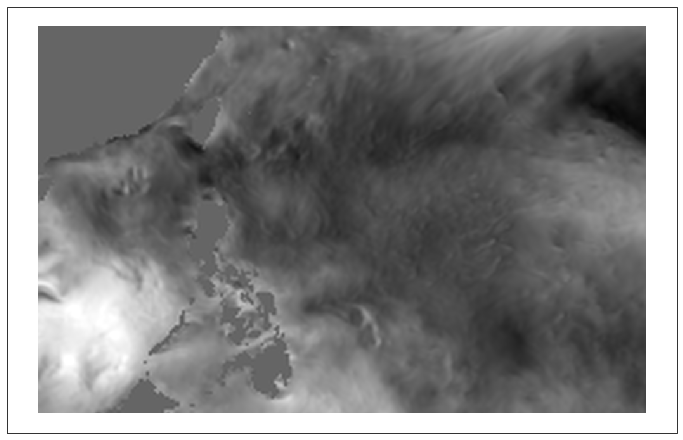

In [6]:
fig = plt.figure(figsize=(12,12))
fig.tight_layout()
fig.subplots_adjust(top=1.25)

crs = ccrs.PlateCarree()

ax = fig.add_subplot(111, facecolor='None', projection=crs)
ax.pcolormesh(lons_i, lats_i, np.flipud(u_i), cmap=cm.gray, vmin=-10, vmax=10)
plt.show()
plt.close(fig)

### Combine plots. <br>

Countries shapefile from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/

In [7]:
df = gpd.read_file('/path/to/shapefile')

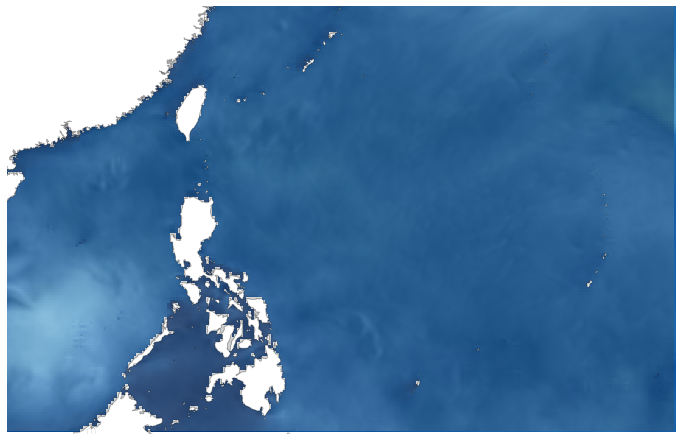

In [8]:
fig = plt.figure(figsize=(12,12))
fig.tight_layout()
fig.subplots_adjust(top=1.25)

crs = ccrs.PlateCarree()

ax = fig.add_subplot(111, facecolor='None', projection=crs)

ax.pcolormesh(lons, lats, swh, cmap=cm.Blues_r, vmin=0, vmax=5)
ax.pcolormesh(lons_i, lats_i, np.flipud(u_i), cmap=cm.gray, alpha=0.3,vmin=-10, vmax=10)

df.plot(facecolor='white', edgecolor='black', linewidth=.05, ax=ax)

ax.coastlines(resolution='10m', alpha=0.25, color='black')
ax.axis('off')

plt.xlim((lon_min,lon_max))
plt.ylim((lat_min,lat_max))

plt.show()
plt.close(fig)